# In this notebook I will explore techniques to evaluate and improve machine learning models

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.keras.backend.set_floatx('float64')
tf.autograph.set_verbosity(0)

2025-04-22 14:57:36.004880: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 14:57:36.034934: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-22 14:57:36.485128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')
dlblue = '#0096ff'; dlorange = '#FF9300'; dldarkred='#C00000'; dlmagenta='#FF40FF'; dlpurple='#7030A0'; dldarkblue =  '#0D5BDC'
dlcolors = [dlblue, dlorange, dldarkred, dlmagenta, dlpurple]

In [3]:
def gen_data(m, seed=1, scale=0.7):
    """ Generate a data set based on a x^2 with added noise """

    c = 0
    x_train = np.linspace(0,49,m)
    np.random.seed(seed)
    y_ideal = x_train**2 + c
    y_train = y_ideal + scale * y_ideal * (np.random.sample((m,))-0.5)
    x_ideal = x_train # for redraw when new data included in X
    return  x_train, y_train, x_ideal, y_ideal

# Split the data

In [4]:
# Generate the data
X, y, x_ideal, y_ideal = gen_data(18, 2, 0.7)
print("X.shape:", X.shape, "y.shape: ", y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print("X_train.shape:", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape:", X_test.shape, "y_test.shape", y_test.shape)

X.shape: (18,) y.shape:  (18,)
X_train.shape: (12,) y_train.shape (12,)
X_test.shape: (6,) y_test.shape (6,)


# Plot Train, Test Sets

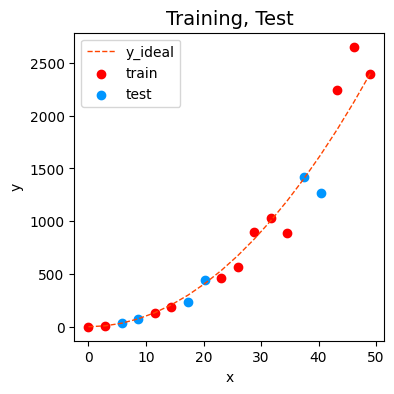

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color='orangered', label="y_ideal", lw=1)
ax.set_title("Training, Test", fontsize=14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color="r", label="train")
ax.scatter(X_test, y_test, color=dlc["dlblue"], label="test")
ax.legend(loc='upper left')
plt.show()

# Error Calculation for model evaluation, linear regression

$$\textbf{J}_{test} (\textbf{w},b) = \frac{1}{2m_{test}} \sum_{i=0}^{m_{test}-1} (f_{\textbf{w},b}(\textbf{x}_{test}^{(i)}) - y_{test}^{(i)})^2$$

I will implement a function to calculate it.

In [6]:
def my_mse(y, yhat):
    """ 
        Calculate the mean square error on a data set.

        Args:
            y           :  (ndarray(m,) or (m,1))   Target value of each example
            yhat        :  (ndarray(m,) or (m,1)    Predicted value of each example
    
        Returns:
            err(scalar) : mean square error
    """

    m = len(y)
    err = 0.0

    for i in range(m):
        err += (y[i] - yhat[i])**2
        
    err = err / (2*m)

    return (err)

# Compare performance on training and test data

Let's build a high degree polynomial model to minimize the error.

In [7]:
# Create a model in sklearn
class lin_model:
    def __init__(self, degree, regularization=False, lambda_=0):
        if regularization:
            self.linear_model = Ridge(alpha=lambda_)
        else:
            self.linear_model = LinearRegression()
        self.poly = PolynomialFeatures(degree, include_bias=False)
        self.scaler = StandardScaler()

    def fit(self, X_train, y_train):
        """ Just fits the data. Mapping and scaling are not repeated"""
        X_train_mapped = self.poly.fit_transform(X_train.reshape(-1,1))
        X_train_mapped_scaled = self.scaler.fit_transform(X_train_mapped)
        self.linear_model.fit(X_train_mapped_scaled, y_train)

    def predict(self, X):
        X_mapped = self.poly.transform(X.reshape(-1,1))
        X_mapped_scaled = self.scaler.transform(X_mapped)
        yhat = self.linear_model.predict(X_mapped_scaled)
        return yhat
    
    def mse(self, y, yhat):
        err = mean_squared_error(y, yhat) / 2
        return (err)

In [8]:
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# Predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# Predict on test data, find test error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

In [9]:
print(f"Training error: {err_train:.2f}, Test error: {err_test:.2f}")

Training error: 58.01, Test error: 171215.01


I can observe that the test error is too high. Let's explore why this is in a plot.

In [10]:
def plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree):
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax.plot(x_ideal, y_ideal, "--", color='orangered', label="y_ideal", lw=1)
    ax.set_title("Poor Performance on Test Data", fontsize=12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")


    ax.scatter(X_train, y_train, color=dlc["dldarkred"], label="Train")
    ax.scatter(X_test, y_test, color=dlc["dldarkblue"], label="Test")
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    ax.plot(x, y_pred, lw=0.5, color=dlc["dlblue"], label=f"Predicted, degree={degree}")
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

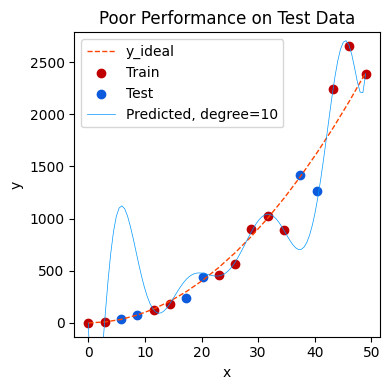

In [11]:
x = np.linspace(0, int(X.max()), 100) # Predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, 10)

As we saw previously, the test error is too high. That means the model will perform bad on new data. According to the split, I used 66.67% for train and 33.33% for test. However, these quantities can vary depending on the size of the data set. Let's explore another alternatives.

In [12]:
# Generate data
X, y, x_ideal, y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape,"Y.shape", y.shape)

# Split the data using sklearn routine
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.50, random_state=1)

del X_, y_

print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) Y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


# Bias and Invariance

Moreover, the degree of the polynomial model was too high. I should change it, but how can I choose a good value? I will try a range of degree values and calculate the performance using the training and cross validation set.

# Train, Cross Validation and Test Visualization

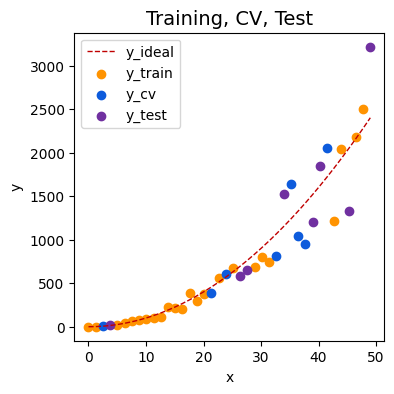

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color=dlc["dldarkred"], label="y_ideal", lw=1)
ax.scatter(X_train, y_train, color=dlc["dlorange"], label="y_train")
ax.scatter(X_cv, y_cv, color=dlc["dldarkblue"], label="y_cv")
ax.scatter(X_test, y_test, color=dlc["dlpurple"], label="y_test")

ax.set_title("Training, CV, Test", fontsize=14)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(loc='upper left')
plt.show()



# Finding the optimal degree

I will use the `scikit-learn` linear regression moderl for speed and simplicity.

In [20]:
max_degree = 9
err_train = np.zeros(max_degree)
err_cv = np.zeros(max_degree)
x = np.linspace(0, int(X.max()), 100)
y_pred = np.zeros((100, max_degree)) # columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)

optimal_degree = np.argmin(err_cv)+1

In [21]:
print(optimal_degree)

2


# Plot the result

In [84]:
def plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, err_train, err_cv, optimal_degree, max_degree):
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
    ax[0].scatter(X_train, y_train, color = "black", marker='v',          label="train")
    ax[0].scatter(X_cv, y_cv,       color = "teal", marker='d', label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
    for i in range(0,max_degree):
        ax[0].plot(x, y_pred[:,i],  lw=0.6, label=f"{i+1}")
    ax[0].legend(loc='upper left')

    ax[1].set_title("error vs degree",fontsize = 12)
    cpts = list(range(1, max_degree+1))
    ax[1].plot(cpts, err_train[0:], marker='o',label="train error", lw=2,  color = dlc["dlblue"])
    ax[1].plot(cpts, err_cv[0:],    marker='o',label="cv error",  lw=2, color = dlc["dlorange"])
    ax[1].set_ylim(*ax[1].get_ylim())
    ax[1].axvline(optimal_degree, lw=1, color = dlc["dlmagenta"])
    ax[1].annotate("optimal degree", xy=(optimal_degree,80000),xycoords='data',
                xytext=(0.3, 0.8), textcoords='axes fraction', fontsize=10,
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3", 
                                   color=dlc['dldarkred'], lw=1))
    ax[1].set_xlabel("degree")
    ax[1].set_ylabel("error")
    ax[1].legend()
    fig.suptitle("Find Optimal Degree",fontsize = 12)
    plt.tight_layout()

    plt.show()

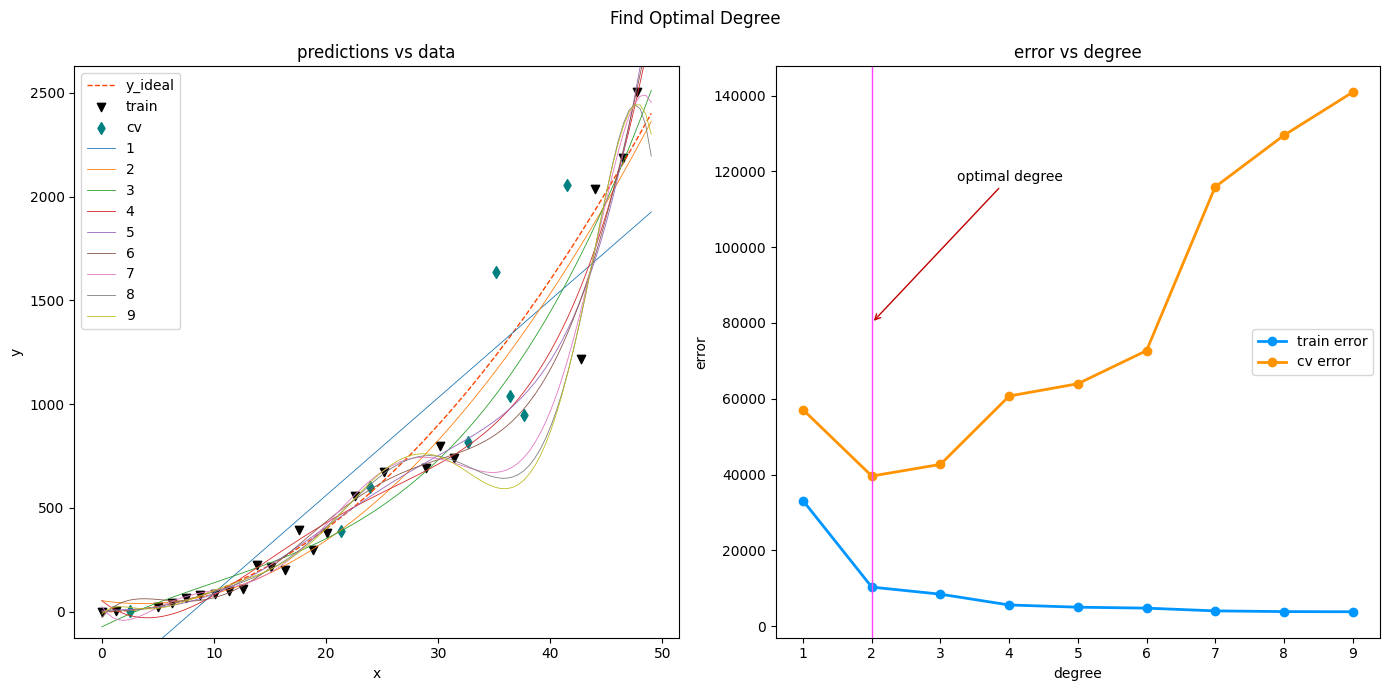

In [85]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, err_train, err_cv, optimal_degree, max_degree)

I can notice in the left plot that the higher the degree is, the better fits to the train data. However, in the right plot, I realize that the train error starts to decrease while the degree increase. Conversely, the cross validation error starts to decrease for a 2-degree model, but it increases for higher degrees leading to over-fit on the training data.

# Tuning Regularization

In the step, I will to tune the regularization parameter lambda $\lambda$ .

In [87]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)
err_cv = np.zeros(num_steps)
x = np.linspace(0, int(X.max()), 100)
y_pred = np.zeros((100, num_steps))     # columns are lines to plot

for i in range(num_steps):
    lambda_ = lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_= lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)

optimal_reg_idx = np.argmin(err_cv)

In [88]:
print(optimal_reg_idx)

7


In [89]:
def plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range):
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

    ax[0].set_title("predictions vs data",fontsize = 12)
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    ax[0].scatter(X_train, y_train, color = "red",           label="train")
    ax[0].scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
    ax[0].set_xlim(ax[0].get_xlim())
    ax[0].set_ylim(ax[0].get_ylim())
#   ax[0].plot(x, y_pred[:,:],  lw=0.5, label=[f"$\lambda =${i}" for i in lambda_range])
    for i in (0,3,7,9):
        ax[0].plot(x, y_pred[:,i],  lw=0.5, label=f"$\lambda =${lambda_range[i]}")
    ax[0].legend()

    ax[1].set_title("error vs regularization",fontsize = 12)
    ax[1].plot(lambda_range, err_train[:], label="train error", color = dlc["dlblue"])
    ax[1].plot(lambda_range, err_cv[:],    label="cv error",    color = dlc["dlorange"])
    ax[1].set_xscale('log')
    ax[1].set_ylim(*ax[1].get_ylim())
    opt_x = lambda_range[optimal_reg_idx]
    ax[1].vlines(opt_x, *ax[1].get_ylim(), color = "black", lw=1)
    ax[1].annotate("optimal lambda", (opt_x,150000), xytext=(-80,10), textcoords="offset points",
                  arrowprops={'arrowstyle':'simple'})
    ax[1].set_xlabel("regularization (lambda)")
    ax[1].set_ylabel("error")
    fig.suptitle("Tuning Regularization",fontsize = 12)
    ax[1].text(0.05,0.44,"High\nVariance",fontsize=12, ha='left',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].text(0.95,0.44,"High\nBias",    fontsize=12, ha='right',transform=ax[1].transAxes,color = dlc["dlblue"])
    ax[1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

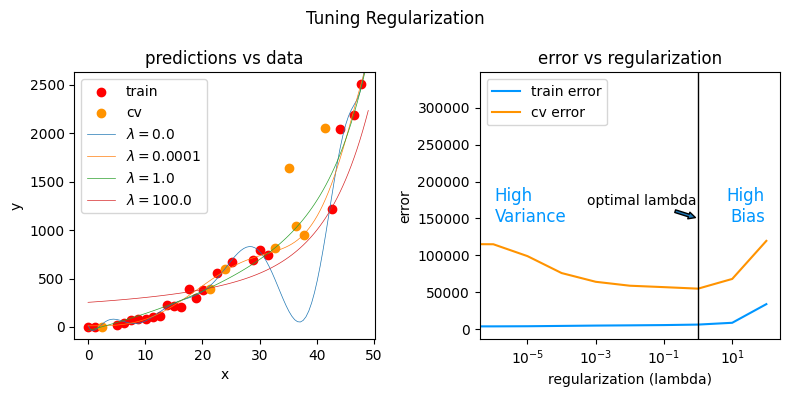

In [90]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 